# 01_Data_Load_and_Preprocess

## Cel

Celem tego notebooka jest:

- Wczytanie i analiza surowych danych.
- Identyfikacja i przetwarzanie brakujących danych w sposób spójny dla zbioru treningowego i testowego.
- Przygotowanie danych do dalszego modelowania poprzez imputację braków i standaryzację cech.



## Kroki
**1. Wczytanie danych oraz niezbędne biblioteki**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

train_file_path = "../Data/train.csv"  
test_file_path = "../Data/test.csv"

train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

**2. Obliczenie braków danych**

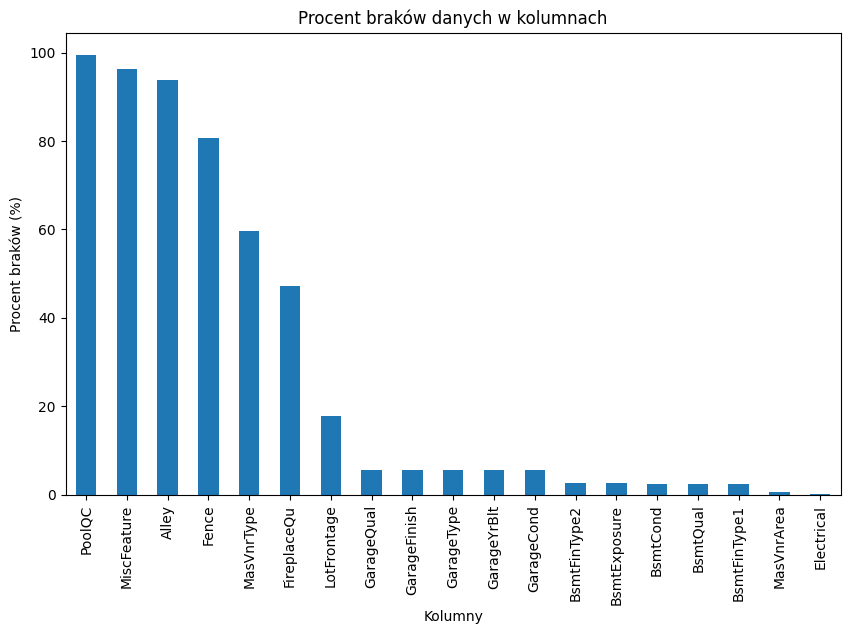

In [2]:
missing_data = train_df.isnull().sum()
missing_percentage = (missing_data / len(train_df)) * 100
missing_summary = pd.DataFrame({
    'Missing Values': missing_data,
    'Percentage': missing_percentage
}).sort_values(by='Percentage', ascending=False)
    
plt.figure(figsize=(10, 6))
missing_summary[missing_summary['Missing Values'] > 0]['Percentage'].plot(kind='bar')
plt.title('Procent braków danych w kolumnach')
plt.xlabel('Kolumny')
plt.ylabel('Procent braków (%)')
plt.xticks(rotation=90)
plt.show()


**4. Imputacja brakujących danych**

Przeprowadzono imputację braków danych przy użyciu strategii dostosowanej do rodzaju i znaczenia każdej kolumny:

- Numeryczne kolumny: Brakujące wartości wypełniono medianą obliczoną w odpowiednich grupach (np. LotFrontage wypełniono medianą według sąsiedztwa (Neighborhood)), aby lepiej odzwierciedlić lokalne właściwości i zminimalizować wpływ wartości odstających. Dodatkowo, kolumny takie jak GarageYrBlt i MasVnrArea uzupełniono wartością 0, co oznacza brak garażu lub okładziny kamiennej.

- Kategoryczne kolumny: Braki zostały zastąpione wartościami opisowymi, które odzwierciedlają brakujące obiekty lub cechy:
    - "None" dla brakujących obiektów, takich jak brak basenu (PoolQC), brak ogrodzenia (Fence), brak kominka (FireplaceQu), brak garażu (GarageType, GarageQual).
    - Najczęściej występującą wartością (mode) dla kolumn takich jak Electrical, w których brak danych jest rzadki i może wynikać z błędów pomiarowych.

In [3]:
lot_frontage_median = train_df.groupby('Neighborhood')['LotFrontage'].median()

def fill_lot_frontage(row):
    if pd.isnull(row['LotFrontage']):
        return lot_frontage_median[row['Neighborhood']]
    return row['LotFrontage']

fill_values = {
    'PoolQC': 'None',       # Brak basenu oznaczony jako "None"
    'MiscFeature': 'None',  # Brak dodatkowych funkcji (np. brak szopy, kortu tenisowego itp.)
    'Alley': 'None',        # Brak dostępu do alei (np. brak drogi żwirowej lub brukowanej)
    'Fence': 'None',        # Brak ogrodzenia (np. brak ogrodzenia prywatnego lub drewnianego)
    'FireplaceQu': 'None',  # Brak kominka (np. brak kominka w nieruchomości)
    'GarageYrBlt': 0,       # Brak garażu, oznaczenie roku budowy jako 0
    'GarageCond': 'None',   # Brak garażu lub brak informacji o jego stanie
    'GarageType': 'None',   # Brak garażu (np. brak garażu wbudowanego, wolnostojącego itp.)
    'GarageFinish': 'None', # Brak garażu lub brak wykończenia wnętrza garażu
    'GarageQual': 'None',   # Brak garażu lub brak informacji o jego jakości
    'MasVnrType': 'None',   # Brak okładziny kamiennej lub brak informacji o jej typie
    'MasVnrArea': 0,        # Brak okładziny kamiennej, wartość powierzchni ustawiona na 0
    'BsmtExposure': 'None', # Brak piwnicy lub brak okien wychodzących na zewnątrz
    'BsmtFinType2': 'None', # Brak piwnicy lub brak informacji o drugim typie wykończenia
    'BsmtCond': 'None',     # Brak piwnicy lub brak informacji o stanie piwnicy
    'BsmtQual': 'None',     # Brak piwnicy lub brak informacji o jej wysokości
    'BsmtFinType1': 'None', # Brak piwnicy lub brak informacji o typie wykończenia
    'Electrical': train_df['Electrical'].mode()[0]  # Najczęściej występujący typ instalacji elektrycznej (np. SBrkr)
}


for col, value in fill_values.items():
    if col in train_df.columns:
        train_df[col] = train_df[col].fillna(value)
    if col in test_df.columns:
        test_df[col] = test_df[col].fillna(value)

train_df['LotFrontage'] = train_df.apply(fill_lot_frontage, axis=1)
if 'LotFrontage' in test_df.columns:
    test_df['LotFrontage'] = test_df.apply(fill_lot_frontage, axis=1)

print("\nBraki danych po imputacji:")
print(train_df.isnull().sum().sort_values(ascending=False).head())



Braki danych po imputacji:
Id             0
MSSubClass     0
MSZoning       0
LotFrontage    0
LotArea        0
dtype: int64


**3. Rozdzielenie kolumn na numeryczne i kategoryczne**


In [4]:
numerical_columns = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = train_df.select_dtypes(include=['object']).columns.tolist()

print("Kolumny numeryczne:")
print(numerical_columns)

print("\nKolumny kategoryczne:")
print(categorical_columns)

print(f"\nPodsumowanie:")
print(f"Liczba kolumn numerycznych: {len(numerical_columns)}")
print(f"Liczba kolumn kategorycznych: {len(categorical_columns)}")
print(f"Liczba wszystkich kolumn: {len(train_df.columns)}")



Kolumny numeryczne:
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']

Kolumny kategoryczne:
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'Firepl

**4. Analiza korelacji dla danych numerycznych**

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.472614
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.349876
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
GarageYrBlt      0.261366
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

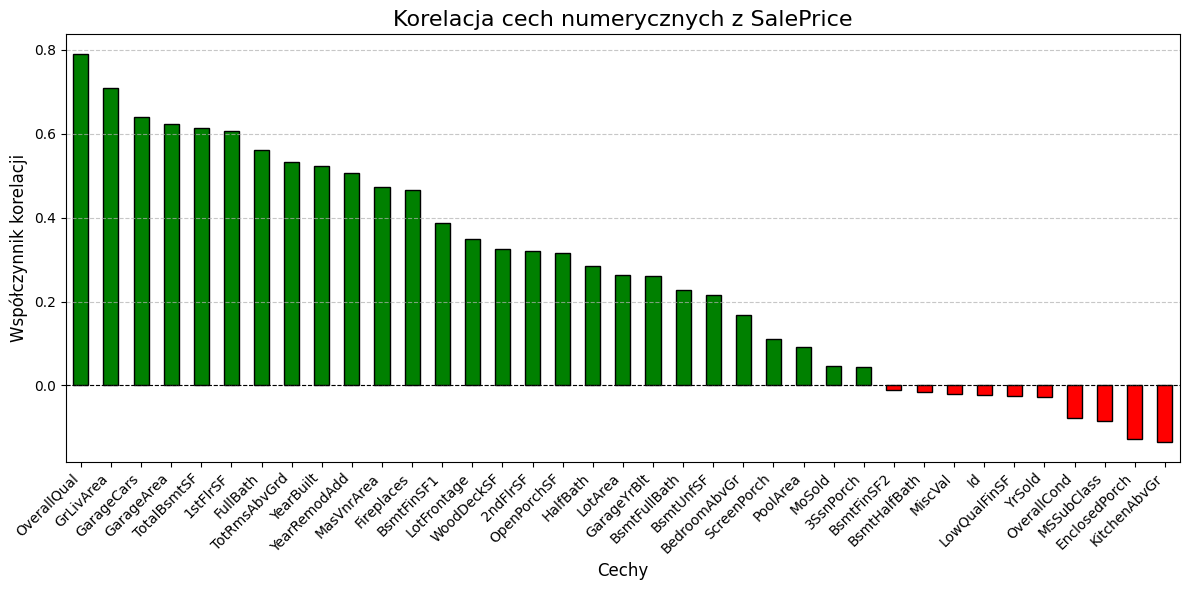

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_data = train_df[numerical_columns]
correlation_with_saleprice = numerical_data.corr()['SalePrice'].sort_values(ascending=False)

print(correlation_with_saleprice)
plt.figure(figsize=(12, 6))
colors = ['green' if val > 0 else 'red' for val in correlation_with_saleprice.drop('SalePrice')]
correlation_with_saleprice.drop('SalePrice').plot(kind='bar', color=colors, edgecolor='black')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title("Korelacja cech numerycznych z SalePrice", fontsize=16)
plt.ylabel("Współczynnik korelacji", fontsize=12)
plt.xlabel("Cechy", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**5. Kodowanie zmiennych kategorycznych z użyciem One-hot encoding**

In [17]:
train_encoded = pd.get_dummies(train_df, columns=categorical_columns, drop_first=True)
test_encoded = pd.get_dummies(test_df, columns=categorical_columns, drop_first=True)

